# Analyzing Events Using ctapipe

<div align="center" style="font-size: 2rem">

<img heoght="300px" src="https://cta-observatory.github.io/ctapipe/_images/ctapipe_logo.png" alt="ctapipe"/>


<p style="text-align: center;">Initially presented @ LST Analysis Bootcamp</p>

<p style="text-align: center">Padova, 26.11.2018</p>

<p style="text-align: center">Maximilian Nöthe (@maxnoe) & Kai A. Brügge (@mackaiver)</p>

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize']

[12.0, 8.0]

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## General Information

### Design

* DL0 → DL3 analysis

* Currently some R0 → DL2 code to be able to analyze simtel files

* ctapipe is built upon the Scientific Python Stack, core dependencies are
  * numpy
  * scipy
  * astropy
  * numba

### Developement

* ctapipe is developed as Open Source Software (Currently under MIT License) at <https://github.com/cta-observatory/ctapipe>

* We use the "Github-Workflow": 
  * Few people (e.g. @kosack, @maxnoe) have write access to the main repository
  * Contributors fork the main repository and work on branches
  * Pull Requests are merged after Code Review and automatic execution of the test suite

* Early developement stage ⇒ backwards-incompatible API changes might and will happen 


### What's there?

* Reading simtel simulation files
* Simple calibration, cleaning and feature extraction functions
* Camera and Array plotting
* Coordinate frames and transformations 
* Stereo-reconstruction using line intersections
  
 

### What's still missing?

* Good integration with machine learning techniques
* IRF calculation 
* Documentation, e.g. formal definitions of coordinate frames  

### What can you do?

* Report issues
  * Hard to get started? Tell us where you are stuck
  * Tell user stories
  * Missing features

* Start contributing
  * ctapipe needs more workpower
  * Implement new reconstruction features

## A simple hillas analysis

### Reading in simtel files

In [3]:
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path

input_url = get_dataset_path('gamma_test_large.simtel.gz')

# EventSource() automatically detects what kind of file we are giving it,
# if already supported by ctapipe
source = EventSource(input_url, max_events=49)

print(type(source))

<class 'ctapipe.io.simteleventsource.SimTelEventSource'>


In [4]:
for event in source:
    print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.simulation.shower.energy, len(event.r0.tel)))

Id: 0, E = 0.571 TeV, Telescopes: 4


Id: 1, E = 1.864 TeV, Telescopes: 9
Id: 2, E = 1.864 TeV, Telescopes: 4
Id: 3, E = 1.864 TeV, Telescopes: 17
Id: 4, E = 1.864 TeV, Telescopes: 2
Id: 5, E = 0.464 TeV, Telescopes: 7


Id: 6, E = 0.017 TeV, Telescopes: 2
Id: 7, E = 76.426 TeV, Telescopes: 4
Id: 8, E = 76.426 TeV, Telescopes: 16
Id: 9, E = 76.426 TeV, Telescopes: 3
Id: 10, E = 0.267 TeV, Telescopes: 5
Id: 11, E = 0.010 TeV, Telescopes: 2
Id: 12, E = 1.407 TeV, Telescopes: 3
Id: 13, E = 1.407 TeV, Telescopes: 3


Id: 14, E = 0.121 TeV, Telescopes: 10
Id: 15, E = 0.032 TeV, Telescopes: 4
Id: 16, E = 0.073 TeV, Telescopes: 2


Id: 17, E = 0.129 TeV, Telescopes: 3
Id: 18, E = 0.129 TeV, Telescopes: 2
Id: 19, E = 10.220 TeV, Telescopes: 2
Id: 20, E = 10.220 TeV, Telescopes: 4
Id: 21, E = 10.220 TeV, Telescopes: 4
Id: 22, E = 0.055 TeV, Telescopes: 2
Id: 23, E = 0.100 TeV, Telescopes: 3
Id: 24, E = 0.079 TeV, Telescopes: 5


Id: 25, E = 0.127 TeV, Telescopes: 7
Id: 26, E = 3.923 TeV, Telescopes: 4
Id: 27, E = 3.923 TeV, Telescopes: 2
Id: 28, E = 3.923 TeV, Telescopes: 4
Id: 29, E = 0.147 TeV, Telescopes: 6
Id: 30, E = 0.974 TeV, Telescopes: 6
Id: 31, E = 0.974 TeV, Telescopes: 3
Id: 32, E = 0.474 TeV, Telescopes: 4
Id: 33, E = 0.474 TeV, Telescopes: 4


Id: 34, E = 0.110 TeV, Telescopes: 2
Id: 35, E = 0.103 TeV, Telescopes: 2
Id: 36, E = 0.120 TeV, Telescopes: 4
Id: 37, E = 0.078 TeV, Telescopes: 4
Id: 38, E = 0.079 TeV, Telescopes: 2
Id: 39, E = 0.592 TeV, Telescopes: 4


Id: 40, E = 0.066 TeV, Telescopes: 6
Id: 41, E = 0.126 TeV, Telescopes: 3
Id: 42, E = 0.126 TeV, Telescopes: 2
Id: 43, E = 0.129 TeV, Telescopes: 2


Id: 44, E = 0.017 TeV, Telescopes: 3


Id: 45, E = 0.053 TeV, Telescopes: 2
Id: 46, E = 0.009 TeV, Telescopes: 2
Id: 47, E = 0.248 TeV, Telescopes: 4
Id: 48, E = 0.248 TeV, Telescopes: 11


Each event is a `DataContainer` holding several `Field`s of data, which can be containers or just numbers.
Let's look a one event:

In [5]:
event

ctapipe.containers.ArrayEventContainer:
                       index.*: event indexing information
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: DL2 reconstruction info
                  simulation.*: Simulated Event Information
                     trigger.*: central trigger information
                         count: number of events processed
                    pointing.*: Array and telescope pointing positions
                 calibration.*: Container for calibration coefficients for the
                                current event
                         mon.*: container for event-wise monitoring data (MON)

In [6]:
source.subarray.camera_types

[CameraDescription(camera_name=ASTRICam, geometry=ASTRICam, readout=ASTRICam),
 CameraDescription(camera_name=LSTCam, geometry=LSTCam, readout=LSTCam),
 CameraDescription(camera_name=FlashCam, geometry=FlashCam, readout=FlashCam)]

In [7]:
len(event.r0.tel), len(event.r1.tel)

(11, 11)

### Data calibration

The `CameraCalibrator` calibrates the event (obtaining the `dl1` images).

In [8]:
from ctapipe.calib import CameraCalibrator

calibrator = CameraCalibrator(subarray=source.subarray)

In [9]:
calibrator(event)

### Event displays

Let's use ctapipe's plotting facilities to plot the telescope images

In [10]:
event.dl1.tel.keys()

dict_keys([1, 2, 3, 4, 5, 7, 9, 11, 13, 16, 19])

In [11]:
tel_id = 4

In [12]:
geometry = source.subarray.tel[tel_id].camera.geometry
dl1 = event.dl1.tel[tel_id]

geometry, dl1

(CameraGeometry(camera_name='LSTCam', pix_type=PixelShape.HEXAGON, npix=1855, cam_rot=0.000 deg, pix_rot=100.893 deg, frame=<CameraFrame Frame (focal_length=28.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>),
 ctapipe.containers.DL1CameraContainer:
                          image: Numpy array of camera image, after waveform
                                 extraction.Shape: (n_pixel) as a 1-D array with
                                 type float32
                      peak_time: Numpy array containing position of the peak of
                                 the pulse as determined by the extractor. Shape:
                                 (n_pixel, ) as a 1-D array with type float32
                     image_mask: Boolean numpy array where True means the pixel
                                 has passed cleaning. Shape: (n_pixel, ) as a 1-D
                                 array with type bool
                       is_valid: True if image extraction su

In [13]:
dl1.image

array([ 1.8977832 , -1.7927673 ,  1.8373003 , ..., -1.330724  ,
        1.0946255 ,  0.36395848], dtype=float32)

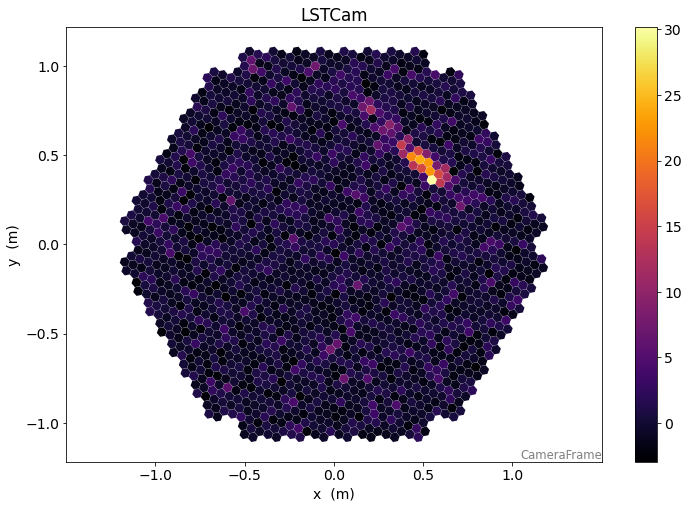

In [14]:
from ctapipe.visualization import CameraDisplay

display = CameraDisplay(geometry)

# right now, there might be one image per gain channel.
# This will change as soon as 
display.image = dl1.image
display.add_colorbar()

### Image Cleaning

In [15]:
from ctapipe.image.cleaning import tailcuts_clean

In [16]:
# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}

In [17]:
boundary, picture, min_neighbors = cleaning_level[geometry.camera_name]

clean = tailcuts_clean(
    geometry, 
    dl1.image,
    boundary_thresh=boundary,
    picture_thresh=picture,
    min_number_picture_neighbors=min_neighbors
)

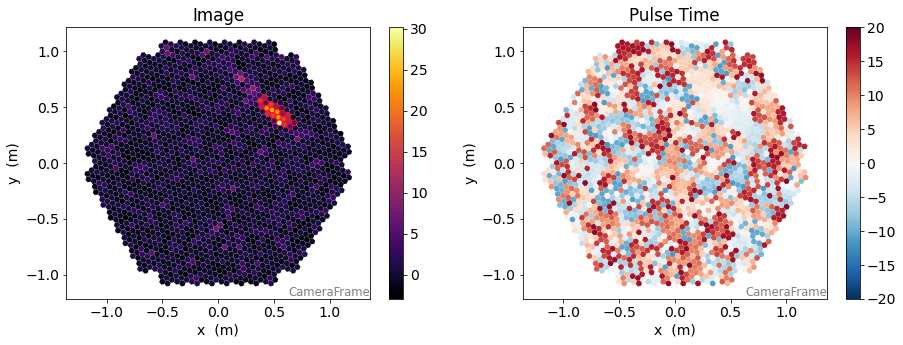

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

d1 = CameraDisplay(geometry, ax=ax1)
d2 = CameraDisplay(geometry, ax=ax2)

ax1.set_title('Image')
d1.image = dl1.image
d1.add_colorbar(ax=ax1)

ax2.set_title('Pulse Time')
d2.image = dl1.peak_time - np.average(dl1.peak_time, weights=dl1.image)
d2.cmap = 'RdBu_r'
d2.add_colorbar(ax=ax2)
d2.set_limits_minmax(-20,20)

d1.highlight_pixels(clean, color='red', linewidth=1)

### Image Parameters

In [19]:
from ctapipe.image import hillas_parameters, leakage_parameters, concentration_parameters
from ctapipe.image import timing_parameters
from ctapipe.image import number_of_islands
from ctapipe.image import camera_to_shower_coordinates

In [20]:
hillas = hillas_parameters(geometry[clean], dl1.image[clean])

print(hillas)

{'intensity': 293.30156207084656,
 'kurtosis': 2.1156918832117624,
 'length': <Quantity 0.09458967 m>,
 'length_uncertainty': <Quantity 0.00291695 m>,
 'phi': <Angle 0.71440377 rad>,
 'psi': <Angle -0.71608044 rad>,
 'r': <Quantity 0.67893267 m>,
 'skewness': -0.15071029797454388,
 'width': <Quantity 0.03181493 m>,
 'width_uncertainty': <Quantity 0.00096868 m>,
 'x': <Quantity 0.51292278 m>,
 'y': <Quantity 0.44481435 m>}


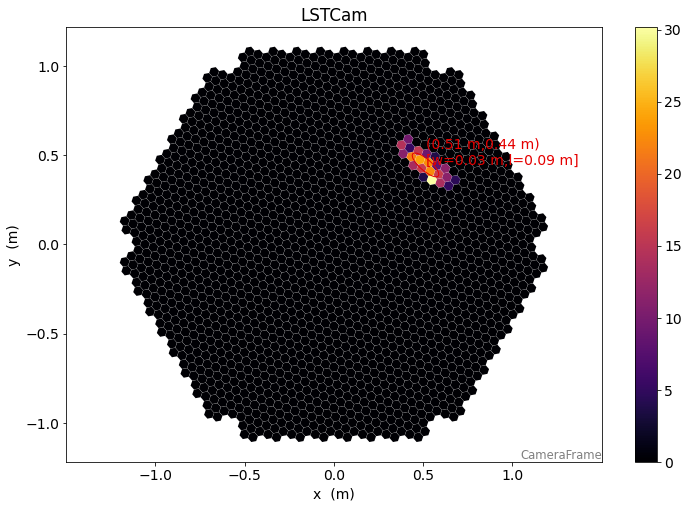

In [21]:
display = CameraDisplay(geometry)

# set "unclean" pixels to 0
cleaned = dl1.image.copy()
cleaned[~clean] = 0.0

display.image = cleaned
display.add_colorbar()

display.overlay_moments(hillas, color='xkcd:red')

In [22]:
timing = timing_parameters(
    geometry,
    dl1.image,
    dl1.peak_time,
    hillas,
    clean
)

print(timing)

{'deviation': 0.5507465160185104,
 'intercept': 30.871464798739247,
 'slope': <Quantity -5.81771647 1 / m>}


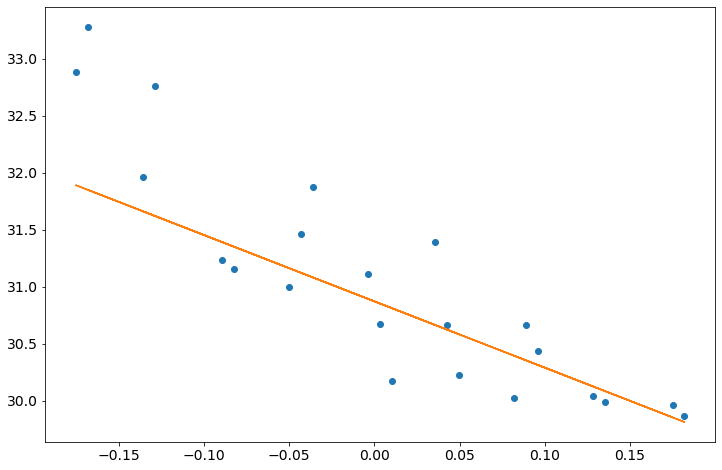

In [23]:
long, trans = camera_to_shower_coordinates(
    geometry.pix_x, geometry.pix_y,hillas.x, hillas.y, hillas.psi
)

plt.plot(long[clean], dl1.peak_time[clean], 'o')
plt.plot(long[clean], timing.slope * long[clean] + timing.intercept)

In [24]:
l = leakage_parameters(geometry, dl1.image, clean)
print(l)

{'intensity_width_1': 0.0,
 'intensity_width_2': 0.0,
 'pixels_width_1': 0.0,
 'pixels_width_2': 0.0}


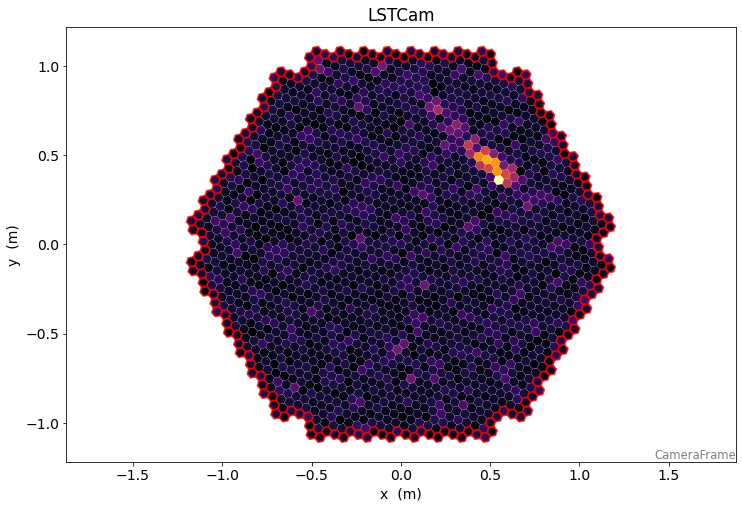

In [25]:
disp = CameraDisplay(geometry)
disp.image = dl1.image
disp.highlight_pixels(geometry.get_border_pixel_mask(1), linewidth=2, color='xkcd:red')

In [26]:
n_islands, island_id = number_of_islands(geometry, clean)

print(n_islands)

1


In [27]:
conc = concentration_parameters(geometry, dl1.image, hillas)
print(conc)

{'cog': 0.2901097326436822,
 'core': 0.34470898401576955,
 'pixel': 0.10290955973463788}


### Putting it all together / Stereo reconstruction


All these steps are now unified in several components configurable through the config system, mainly:

* CameraCalibrator for DL0 → DL1 (Images)
* ImageProcessor for DL1 (Images) → DL1 (Parameters)
* ShowerProcessor for stereo reconstruction of the shower geometry
* DataWriter for writing data into HDF5

A command line tool doing these steps and writing out data in HDF5 format is available as `ctapipe-process`

In [28]:
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz

from ctapipe.containers import ImageParametersContainer
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator

from ctapipe.image import ImageProcessor
from ctapipe.reco import ShowerProcessor

from ctapipe.io import DataWriter

from copy import deepcopy
import tempfile

from traitlets.config import Config


image_processor_config = Config({
    "ImageProcessor": {
        "image_cleaner_type": "TailcutsImageCleaner",
        "TailcutsImageCleaner": {
            "picture_threshold_pe": [
                ("type", "LST_LST_LSTCam", 7.5),
                ("type", "MST_MST_FlashCam", 8),
                ("type", "SST_ASTRI_ASTRICam", 7),
            ],
            "boundary_threshold_pe": [
                ("type", "LST_LST_LSTCam", 5),
                ("type", "MST_MST_FlashCam", 4),
                ("type", "SST_ASTRI_ASTRICam", 4),
            ]
            
        }
    }
})

input_url = get_dataset_path('gamma_test_large.simtel.gz')
source = EventSource(input_url)

calibrator = CameraCalibrator(subarray=source.subarray)
image_processor = ImageProcessor(subarray=source.subarray, config=image_processor_config)
shower_processor = ShowerProcessor(subarray=source.subarray)
horizon_frame = AltAz()

f = tempfile.NamedTemporaryFile(suffix='.hdf5')

with DataWriter(source, output_path=f.name, overwrite=True, write_stereo_shower=True) as writer:
    
    for event in source:
        energy = event.simulation.shower.energy
        n_telescopes_r1 = len(event.r1.tel)
        event_id = event.index.event_id
        print(f'Id: {event_id}, E = {energy:1.3f}, Telescopes (R1): {n_telescopes_r1}')
        
        calibrator(event)
        image_processor(event)
        shower_processor(event)
        
        stereo = event.dl2.stereo.geometry["HillasReconstructor"]
        if stereo.is_valid:
            print('  Alt: {:.2f}°'.format(stereo.alt.deg))
            print('  Az: {:.2f}°'.format(stereo.az.deg))
            print('  Hmax: {:.0f}'.format(stereo.h_max))
            print('  CoreX: {:.1f}'.format(stereo.core_x))
            print('  CoreY: {:.1f}'.format(stereo.core_y))
            print('  Multiplicity: {:d}'.format(len(stereo.tel_ids)))
        
        # save a nice event for plotting later
        if event.count == 3:
            plotting_event = deepcopy(event)
            
        writer(event)

Overwriting /tmp/tmpd9ot51n1.hdf5


Id: 23703, E = 0.571 TeV, Telescopes (R1): 4


  Alt: 66.64°
  Az: -7.61°
  Hmax: 7725 m
  CoreX: 150.2 m
  CoreY: -403.3 m
  Multiplicity: 4
Id: 31007, E = 1.864 TeV, Telescopes (R1): 9


  Alt: 68.27°
  Az: -353.31°
  Hmax: 7837 m
  CoreX: -63.1 m
  CoreY: -352.9 m
  Multiplicity: 9
Id: 31010, E = 1.864 TeV, Telescopes (R1): 4


  Alt: 68.50°
  Az: -354.31°
  Hmax: 7030 m
  CoreX: -417.9 m
  CoreY: -573.1 m
  Multiplicity: 3
Id: 31012, E = 1.864 TeV, Telescopes (R1): 17


  Alt: 68.48°
  Az: -353.56°
  Hmax: 6814 m
  CoreX: 46.8 m
  CoreY: 67.8 m
  Multiplicity: 16


Id: 31019, E = 1.864 TeV, Telescopes (R1): 2
  Alt: 68.65°
  Az: -353.31°
  Hmax: 6406 m
  CoreX: -1096.4 m
  CoreY: 474.8 m
  Multiplicity: 2


Id: 46705, E = 0.464 TeV, Telescopes (R1): 7


  Alt: 71.92°
  Az: -1.07°
  Hmax: 8684 m
  CoreX: -66.1 m
  CoreY: 289.6 m
  Multiplicity: 6


Id: 90914, E = 0.017 TeV, Telescopes (R1): 2
  Alt: 70.49°
  Az: -358.67°
  Hmax: 10832 m
  CoreX: -168.2 m
  CoreY: -267.8 m
  Multiplicity: 2


Id: 135101, E = 76.426 TeV, Telescopes (R1): 4
  Alt: 74.78°
  Az: -354.06°
  Hmax: 6683 m
  CoreX: 93.8 m
  CoreY: -1125.2 m
  Multiplicity: 4


Id: 135104, E = 76.426 TeV, Telescopes (R1): 16


  Alt: 75.16°
  Az: -354.24°
  Hmax: 5937 m
  CoreX: 127.5 m
  CoreY: 443.3 m
  Multiplicity: 15


Id: 135107, E = 76.426 TeV, Telescopes (R1): 3
  Alt: 74.99°
  Az: -354.02°
  Hmax: 7507 m
  CoreX: 912.5 m
  CoreY: -995.1 m
  Multiplicity: 3


Id: 137705, E = 0.267 TeV, Telescopes (R1): 5
  Alt: 67.41°
  Az: -359.65°
  Hmax: 9557 m
  CoreX: -124.9 m
  CoreY: -443.7 m
  Multiplicity: 3
Id: 153614, E = 0.010 TeV, Telescopes (R1): 2


Id: 168706, E = 1.407 TeV, Telescopes (R1): 3
  Alt: 69.07°
  Az: -342.37°
  Hmax: 5217 m
  CoreX: 198.7 m
  CoreY: 116.7 m
  Multiplicity: 3
Id: 168716, E = 1.407 TeV, Telescopes (R1): 3


  Alt: 69.32°
  Az: -344.41°
  Hmax: 3509 m
  CoreX: 170.4 m
  CoreY: 155.8 m
  Multiplicity: 3
Id: 192801, E = 0.121 TeV, Telescopes (R1): 10


  Alt: 67.46°
  Az: -0.47°
  Hmax: 13017 m
  CoreX: -158.4 m
  CoreY: -105.9 m
  Multiplicity: 9
Id: 222202, E = 0.032 TeV, Telescopes (R1): 4


  Alt: 71.90°
  Az: -0.45°
  Hmax: 7844 m
  CoreX: 20.7 m
  CoreY: 66.4 m
  Multiplicity: 4
Id: 229110, E = 0.073 TeV, Telescopes (R1): 2
Id: 261408, E = 0.129 TeV, Telescopes (R1): 3


  Alt: 70.51°
  Az: -352.48°
  Hmax: 4449 m
  CoreX: 210.2 m
  CoreY: -112.2 m
  Multiplicity: 3
Id: 261419, E = 0.129 TeV, Telescopes (R1): 2
Id: 277604, E = 10.220 TeV, Telescopes (R1): 2
Id: 277617, E = 10.220 TeV, Telescopes (R1): 4


  Alt: 64.19°
  Az: -348.40°
  Hmax: 6689 m
  CoreX: -703.0 m
  CoreY: -0.1 m
  Multiplicity: 3
Id: 277618, E = 10.220 TeV, Telescopes (R1): 4
  Alt: 65.57°
  Az: -350.28°
  Hmax: 4822 m
  CoreX: 257.6 m
  CoreY: 311.3 m
  Multiplicity: 3


Id: 287115, E = 0.055 TeV, Telescopes (R1): 2
  Alt: 73.02°
  Az: -1.67°
  Hmax: 7389 m
  CoreX: -335.0 m
  CoreY: 8.7 m
  Multiplicity: 2
Id: 300617, E = 0.100 TeV, Telescopes (R1): 3


  Alt: 68.77°
  Az: -350.24°
  Hmax: 8123 m
  CoreX: -143.9 m
  CoreY: -115.9 m
  Multiplicity: 3
Id: 302408, E = 0.079 TeV, Telescopes (R1): 5
  Alt: 67.96°
  Az: -353.56°
  Hmax: 11072 m
  CoreX: -197.3 m
  CoreY: 71.4 m
  Multiplicity: 5


Id: 380915, E = 0.127 TeV, Telescopes (R1): 7


  Alt: 70.12°
  Az: -4.74°
  Hmax: 8338 m
  CoreX: 30.4 m
  CoreY: -224.0 m
  Multiplicity: 6
Id: 394306, E = 3.923 TeV, Telescopes (R1): 4
  Alt: 70.40°
  Az: -343.47°
  Hmax: 6941 m
  CoreX: 401.6 m
  CoreY: -109.2 m
  Multiplicity: 2


Id: 394309, E = 3.923 TeV, Telescopes (R1): 2
Id: 394312, E = 3.923 TeV, Telescopes (R1): 4


  Alt: 70.01°
  Az: -345.19°
  Hmax: 5882 m
  CoreX: 26.0 m
  CoreY: -249.7 m
  Multiplicity: 3
Id: 396207, E = 0.147 TeV, Telescopes (R1): 6


  Alt: 70.10°
  Az: -3.79°
  Hmax: 5555 m
  CoreX: 131.2 m
  CoreY: 224.3 m
  Multiplicity: 5
Id: 397303, E = 0.974 TeV, Telescopes (R1): 6


  Alt: 73.44°
  Az: -5.94°
  Hmax: 8540 m
  CoreX: 484.8 m
  CoreY: 304.3 m
  Multiplicity: 6
Id: 397308, E = 0.974 TeV, Telescopes (R1): 3
  Alt: 73.33°
  Az: -6.26°
  Hmax: 7722 m
  CoreX: -38.1 m
  CoreY: 594.9 m
  Multiplicity: 3


Id: 446803, E = 0.474 TeV, Telescopes (R1): 4
  Alt: 69.86°
  Az: -11.85°
  Hmax: 7129 m
  CoreX: -131.0 m
  CoreY: -519.2 m
  Multiplicity: 4
Id: 446818, E = 0.474 TeV, Telescopes (R1): 4


  Alt: 69.83°
  Az: -11.51°
  Hmax: 7337 m
  CoreX: 443.4 m
  CoreY: -230.9 m
  Multiplicity: 4
Id: 467714, E = 0.110 TeV, Telescopes (R1): 2
  Alt: 71.91°
  Az: -358.11°
  Hmax: 8842 m
  CoreX: -221.9 m
  CoreY: -7.7 m
  Multiplicity: 2


Id: 500414, E = 0.103 TeV, Telescopes (R1): 2
  Alt: 68.39°
  Az: -356.01°
  Hmax: 1876 m
  CoreX: -472.9 m
  CoreY: 174.3 m
  Multiplicity: 2
Id: 500514, E = 0.120 TeV, Telescopes (R1): 4


  Alt: 68.70°
  Az: -9.47°
  Hmax: 10969 m
  CoreX: 114.7 m
  CoreY: -285.3 m
  Multiplicity: 4
Id: 503315, E = 0.078 TeV, Telescopes (R1): 4
  Alt: 68.62°
  Az: -355.49°
  Hmax: 9737 m
  CoreX: -158.1 m
  CoreY: -125.4 m
  Multiplicity: 4


Id: 520712, E = 0.079 TeV, Telescopes (R1): 2
  Alt: 71.74°
  Az: -351.70°
  Hmax: 10095 m
  CoreX: -116.5 m
  CoreY: -41.6 m
  Multiplicity: 2
Id: 546313, E = 0.592 TeV, Telescopes (R1): 4


  Alt: 66.03°
  Az: -357.92°
  Hmax: 10362 m
  CoreX: -184.9 m
  CoreY: 78.6 m
  Multiplicity: 2


Id: 650211, E = 0.066 TeV, Telescopes (R1): 6
  Alt: 68.86°
  Az: -6.07°
  Hmax: 10624 m
  CoreX: 71.4 m
  CoreY: -12.1 m
  Multiplicity: 5


Id: 662106, E = 0.126 TeV, Telescopes (R1): 3
  Alt: 71.57°
  Az: -355.17°
  Hmax: 7758 m
  CoreX: -210.1 m
  CoreY: -308.9 m
  Multiplicity: 3
Id: 662119, E = 0.126 TeV, Telescopes (R1): 2


  Alt: 71.57°
  Az: -355.98°
  Hmax: 8302 m
  CoreX: -88.3 m
  CoreY: -462.6 m
  Multiplicity: 2
Id: 684607, E = 0.129 TeV, Telescopes (R1): 2
  Alt: 73.55°
  Az: -357.46°
  Hmax: 9607 m
  CoreX: 386.8 m
  CoreY: 36.5 m
  Multiplicity: 2


Id: 735700, E = 0.017 TeV, Telescopes (R1): 3


Id: 823305, E = 0.053 TeV, Telescopes (R1): 2
  Alt: 70.77°
  Az: -355.33°
  Hmax: 10482 m
  CoreX: 461.5 m
  CoreY: -97.6 m
  Multiplicity: 2
Id: 856512, E = 0.009 TeV, Telescopes (R1): 2


Id: 869902, E = 0.248 TeV, Telescopes (R1): 4
  Alt: 71.94°
  Az: -0.06°
  Hmax: 10458 m
  CoreX: 467.2 m
  CoreY: 96.6 m
  Multiplicity: 4
Id: 869911, E = 0.248 TeV, Telescopes (R1): 11


  Alt: 72.04°
  Az: -0.11°
  Hmax: 10320 m
  CoreX: 31.7 m
  CoreY: -148.6 m
  Multiplicity: 11
Id: 869914, E = 0.248 TeV, Telescopes (R1): 4
  Alt: 71.83°
  Az: -359.98°
  Hmax: 8856 m
  CoreX: -450.0 m
  CoreY: 149.1 m
  Multiplicity: 2
Id: 880603, E = 5.327 TeV, Telescopes (R1): 2


  Alt: 66.70°
  Az: -350.00°
  Hmax: 6925 m
  CoreX: -1058.1 m
  CoreY: 868.3 m
  Multiplicity: 2
Id: 880610, E = 5.327 TeV, Telescopes (R1): 18


  Alt: 67.06°
  Az: -351.07°
  Hmax: 6515 m
  CoreX: -342.1 m
  CoreY: 150.9 m
  Multiplicity: 17
Id: 880611, E = 5.327 TeV, Telescopes (R1): 2
  Alt: 67.24°
  Az: -351.38°
  Hmax: 6069 m
  CoreX: -1185.8 m
  CoreY: -412.2 m
  Multiplicity: 2
Id: 882904, E = 0.095 TeV, Telescopes (R1): 2


  Alt: 69.60°
  Az: -9.40°
  Hmax: 13414 m
  CoreX: 125.0 m
  CoreY: 295.1 m
  Multiplicity: 2
Id: 904404, E = 0.937 TeV, Telescopes (R1): 2
Id: 904411, E = 0.937 TeV, Telescopes (R1): 2


  Alt: 69.82°
  Az: -6.89°
  Hmax: 9224 m
  CoreX: -650.1 m
  CoreY: -717.4 m
  Multiplicity: 2
Id: 904412, E = 0.937 TeV, Telescopes (R1): 4
  Alt: 69.76°
  Az: -7.12°
  Hmax: 8854 m
  CoreX: -545.7 m
  CoreY: 151.1 m
  Multiplicity: 4
Id: 904414, E = 0.937 TeV, Telescopes (R1): 2


  Alt: 70.15°
  Az: -6.80°
  Hmax: 9136 m
  CoreX: 414.7 m
  CoreY: 866.7 m
  Multiplicity: 2
Id: 910417, E = 0.161 TeV, Telescopes (R1): 2
  Alt: 71.69°
  Az: -11.54°
  Hmax: 8974 m
  CoreX: 251.4 m
  CoreY: -465.4 m
  Multiplicity: 2


Id: 940800, E = 0.407 TeV, Telescopes (R1): 14


  Alt: 69.54°
  Az: -8.07°
  Hmax: 9782 m
  CoreX: -102.3 m
  CoreY: -148.5 m
  Multiplicity: 14
Id: 952004, E = 0.037 TeV, Telescopes (R1): 3
  Alt: 67.44°
  Az: -358.36°
  Hmax: 14062 m
  CoreX: -454.8 m
  CoreY: 37.9 m
  Multiplicity: 3


Id: 998705, E = 0.020 TeV, Telescopes (R1): 4
  Alt: 70.50°
  Az: -0.63°
  Hmax: 9374 m
  CoreX: -12.0 m
  CoreY: 124.5 m
  Multiplicity: 2


Id: 1044706, E = 2.364 TeV, Telescopes (R1): 4
  Alt: 65.91°
  Az: -359.34°
  Hmax: 8098 m
  CoreX: 570.8 m
  CoreY: 734.7 m
  Multiplicity: 3


Id: 1096802, E = 0.710 TeV, Telescopes (R1): 8


  Alt: 71.33°
  Az: -350.10°
  Hmax: 9016 m
  CoreX: 277.8 m
  CoreY: 179.9 m
  Multiplicity: 8
Id: 1096805, E = 0.710 TeV, Telescopes (R1): 2
  Alt: 71.13°
  Az: -348.31°
  Hmax: 10356 m
  CoreX: 677.8 m
  CoreY: -578.1 m
  Multiplicity: 2


Id: 1147119, E = 1.158 TeV, Telescopes (R1): 2
  Alt: 67.21°
  Az: -6.28°
  Hmax: 7553 m
  CoreX: -527.1 m
  CoreY: 920.7 m
  Multiplicity: 2
Id: 1151704, E = 0.055 TeV, Telescopes (R1): 5


  Alt: 69.98°
  Az: -355.51°
  Hmax: 8572 m
  CoreX: -4.2 m
  CoreY: 152.0 m
  Multiplicity: 5
Id: 1154506, E = 0.032 TeV, Telescopes (R1): 2
Id: 1206809, E = 0.232 TeV, Telescopes (R1): 3


  Alt: 67.46°
  Az: -5.19°
  Hmax: 9417 m
  CoreX: 148.2 m
  CoreY: -476.6 m
  Multiplicity: 3
Id: 1206818, E = 0.232 TeV, Telescopes (R1): 2
Id: 1221503, E = 22.299 TeV, Telescopes (R1): 5


  Alt: 66.97°
  Az: -358.42°
  Hmax: 6898 m
  CoreX: 141.7 m
  CoreY: -857.0 m
  Multiplicity: 4
Id: 1221509, E = 22.299 TeV, Telescopes (R1): 12


  Alt: 64.09°
  Az: -356.48°
  Hmax: 6189 m
  CoreX: -196.5 m
  CoreY: 286.0 m
  Multiplicity: 12
Id: 1234400, E = 0.118 TeV, Telescopes (R1): 3
  Alt: 67.12°
  Az: -4.95°
  Hmax: 9325 m
  CoreX: 167.9 m
  CoreY: 266.9 m
  Multiplicity: 3
Id: 1234402, E = 0.118 TeV, Telescopes (R1): 3


  Alt: 67.22°
  Az: -4.83°
  Hmax: 8972 m
  CoreX: 169.2 m
  CoreY: -189.8 m
  Multiplicity: 3
Id: 1234407, E = 0.118 TeV, Telescopes (R1): 5
  Alt: 67.01°
  Az: -5.36°
  Hmax: 8916 m
  CoreX: -66.0 m
  CoreY: -339.1 m
  Multiplicity: 4


Id: 1256804, E = 0.101 TeV, Telescopes (R1): 2
  Alt: 66.96°
  Az: -357.08°
  Hmax: 12929 m
  CoreX: 7.1 m
  CoreY: -309.5 m
  Multiplicity: 2


Id: 1360502, E = 0.065 TeV, Telescopes (R1): 2
Id: 1366302, E = 3.581 TeV, Telescopes (R1): 2
  Alt: 71.05°
  Az: -350.78°
  Hmax: 9386 m
  CoreX: -382.6 m
  CoreY: -1149.7 m
  Multiplicity: 2
Id: 1366319, E = 3.581 TeV, Telescopes (R1): 5


  Alt: 71.08°
  Az: -350.59°
  Hmax: 8228 m
  CoreX: 185.4 m
  CoreY: -661.5 m
  Multiplicity: 5
Id: 1421018, E = 0.768 TeV, Telescopes (R1): 5


  Alt: 74.62°
  Az: -0.63°
  Hmax: 7150 m
  CoreX: -57.9 m
  CoreY: 168.6 m
  Multiplicity: 3
Id: 1436416, E = 0.290 TeV, Telescopes (R1): 2
Id: 1437013, E = 0.060 TeV, Telescopes (R1): 2
  Alt: 70.76°
  Az: -7.76°
  Hmax: 10922 m
  CoreX: -241.9 m
  CoreY: 93.9 m
  Multiplicity: 2
Id: 1439706, E = 2.967 TeV, Telescopes (R1): 2
Id: 1439710, E = 2.967 TeV, Telescopes (R1): 2


  Alt: 65.55°
  Az: -6.21°
  Hmax: 8511 m
  CoreX: 974.9 m
  CoreY: -324.7 m
  Multiplicity: 2
Id: 1448801, E = 0.142 TeV, Telescopes (R1): 4
  Alt: 69.42°
  Az: -358.78°
  Hmax: 10535 m
  CoreX: -149.3 m
  CoreY: -367.3 m
  Multiplicity: 3


Id: 1448812, E = 0.142 TeV, Telescopes (R1): 2
Id: 1463300, E = 0.435 TeV, Telescopes (R1): 2
Id: 1463312, E = 0.435 TeV, Telescopes (R1): 2


Id: 1520211, E = 0.339 TeV, Telescopes (R1): 4
  Alt: 66.25°
  Az: -1.06°
  Hmax: 8873 m
  CoreX: 294.9 m
  CoreY: 200.3 m
  Multiplicity: 4


Id: 1625713, E = 1.851 TeV, Telescopes (R1): 4
  Alt: 69.60°
  Az: -2.85°
  Hmax: 7793 m
  CoreX: -872.2 m
  CoreY: 99.2 m
  Multiplicity: 4


Id: 1625719, E = 1.851 TeV, Telescopes (R1): 6


  Alt: 69.46°
  Az: -2.52°
  Hmax: 7772 m
  CoreX: -712.5 m
  CoreY: -251.0 m
  Multiplicity: 6
Id: 1633202, E = 0.189 TeV, Telescopes (R1): 11


  Alt: 70.61°
  Az: -3.62°
  Hmax: 8685 m
  CoreX: -51.5 m
  CoreY: -92.8 m
  Multiplicity: 11
Id: 1650600, E = 0.037 TeV, Telescopes (R1): 3
  Alt: 70.69°
  Az: -6.02°
  Hmax: 13061 m
  CoreX: -44.6 m
  CoreY: -1.1 m
  Multiplicity: 3


Id: 1675702, E = 1.620 TeV, Telescopes (R1): 4
  Alt: 69.32°
  Az: -7.08°
  Hmax: 7295 m
  CoreX: -867.7 m
  CoreY: -195.8 m
  Multiplicity: 3
Id: 1675707, E = 1.620 TeV, Telescopes (R1): 2
  Alt: 69.42°
  Az: -7.67°
  Hmax: 7903 m
  CoreX: -333.3 m
  CoreY: -1084.0 m
  Multiplicity: 2


Id: 1675711, E = 1.620 TeV, Telescopes (R1): 3
  Alt: 69.05°
  Az: -7.29°
  Hmax: 8642 m
  CoreX: 770.0 m
  CoreY: -464.2 m
  Multiplicity: 2
Id: 1675713, E = 1.620 TeV, Telescopes (R1): 3


  Alt: 69.26°
  Az: -7.36°
  Hmax: 8223 m
  CoreX: 92.7 m
  CoreY: 863.3 m
  Multiplicity: 3
Id: 1675715, E = 1.620 TeV, Telescopes (R1): 7


  Alt: 69.19°
  Az: -6.66°
  Hmax: 7739 m
  CoreX: 318.0 m
  CoreY: -597.0 m
  Multiplicity: 5
Id: 1676704, E = 0.112 TeV, Telescopes (R1): 3
  Alt: 70.28°
  Az: -357.93°
  Hmax: 10866 m
  CoreX: -83.4 m
  CoreY: -319.4 m
  Multiplicity: 3
Id: 1680611, E = 0.322 TeV, Telescopes (R1): 2


  Alt: 69.40°
  Az: -359.91°
  Hmax: 6798 m
  CoreX: -538.2 m
  CoreY: 62.1 m
  Multiplicity: 2
Id: 1680619, E = 0.322 TeV, Telescopes (R1): 10


  Alt: 69.43°
  Az: -0.75°
  Hmax: 7336 m
  CoreX: -187.0 m
  CoreY: -218.2 m
  Multiplicity: 8
Id: 1705417, E = 6.104 TeV, Telescopes (R1): 4


  Alt: 74.35°
  Az: -4.51°
  Hmax: 6148 m
  CoreX: 316.1 m
  CoreY: 202.1 m
  Multiplicity: 4
Id: 1744307, E = 0.245 TeV, Telescopes (R1): 3
  Alt: 71.72°
  Az: -347.31°
  Hmax: 10132 m
  CoreX: -172.2 m
  CoreY: -124.3 m
  Multiplicity: 2


Id: 1864717, E = 0.636 TeV, Telescopes (R1): 2
  Alt: 66.58°
  Az: -356.27°
  Hmax: 10900 m
  CoreX: 608.2 m
  CoreY: 135.1 m
  Multiplicity: 2
Id: 1864719, E = 0.636 TeV, Telescopes (R1): 4


  Alt: 67.46°
  Az: -357.47°
  Hmax: 9846 m
  CoreX: 294.2 m
  CoreY: 107.2 m
  Multiplicity: 3
Id: 1883505, E = 1.824 TeV, Telescopes (R1): 6


  Alt: 70.25°
  Az: -0.71°
  Hmax: 7163 m
  CoreX: -611.3 m
  CoreY: -409.2 m
  Multiplicity: 5
Id: 1883506, E = 1.824 TeV, Telescopes (R1): 2
Id: 1883517, E = 1.824 TeV, Telescopes (R1): 3
  Alt: 70.20°
  Az: -0.59°
  Hmax: 6884 m
  CoreX: 822.3 m
  CoreY: -123.1 m
  Multiplicity: 3


Id: 1971507, E = 0.538 TeV, Telescopes (R1): 5
  Alt: 69.12°
  Az: -348.34°
  Hmax: 8587 m
  CoreX: -401.7 m
  CoreY: 103.2 m
  Multiplicity: 5


Id: 1971515, E = 0.538 TeV, Telescopes (R1): 2
  Alt: 69.12°
  Az: -348.58°
  Hmax: 9824 m
  CoreX: 632.8 m
  CoreY: 171.9 m
  Multiplicity: 2


In [29]:
from astropy.coordinates.angle_utilities import angular_separation
import pandas as pd

from ctapipe.io import TableLoader

loader = TableLoader(f.name, load_dl2_geometry=True, load_simulated=True)

events = loader.read_subarray_events()

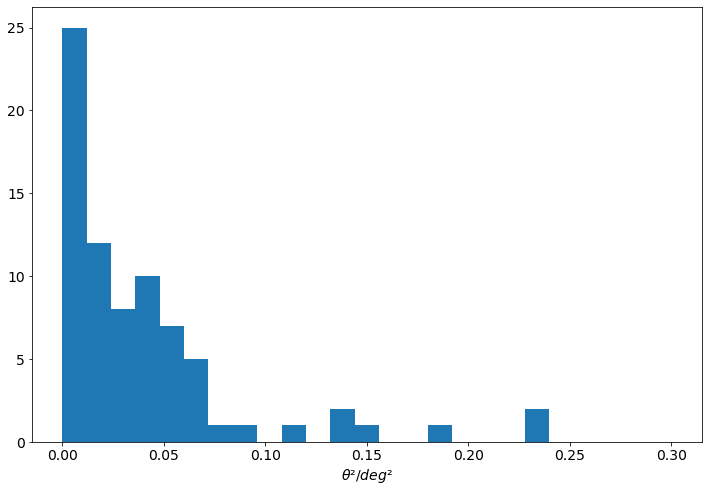

In [30]:
theta = angular_separation(
    events["HillasReconstructor_az"].quantity, events["HillasReconstructor_alt"].quantity,
    events["true_az"].quantity, events["true_alt"].quantity
)

plt.hist(theta.to_value(u.deg)**2, bins=25, range=[0, 0.3])
plt.xlabel(r'$\theta² / deg²$')
None

## ArrayDisplay


(-400.0, 400.0)

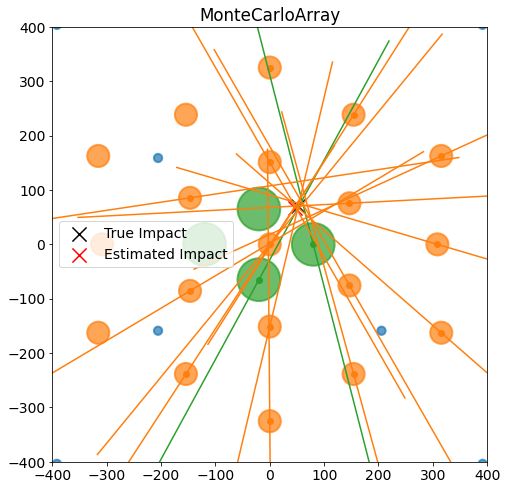

In [31]:
from ctapipe.visualization import ArrayDisplay


angle_offset = plotting_event.pointing.array_azimuth

plotting_hillas = {
    tel_id: dl1.parameters.hillas
    for tel_id, dl1 in plotting_event.dl1.tel.items()
}

plotting_core = {
    tel_id: dl1.parameters.core.psi
    for tel_id, dl1 in plotting_event.dl1.tel.items()
}


disp = ArrayDisplay(source.subarray)

disp.set_line_hillas(plotting_hillas, plotting_core, 500)

plt.scatter(
    plotting_event.simulation.shower.core_x, plotting_event.simulation.shower.core_y,
    s=200, c='k', marker='x', label='True Impact',
)
plt.scatter(
    plotting_event.dl2.stereo.geometry["HillasReconstructor"].core_x,
    plotting_event.dl2.stereo.geometry["HillasReconstructor"].core_y,
    s=200, c='r', marker='x', label='Estimated Impact',
)

plt.legend()
plt.xlim(-400, 400)
plt.ylim(-400, 400)

### Reading the LST dl1 data


In [32]:
loader = TableLoader(f.name, load_simulated=True, load_dl1_parameters=True)

dl1_table = loader.read_telescope_events(["LST_LST_LSTCam"])

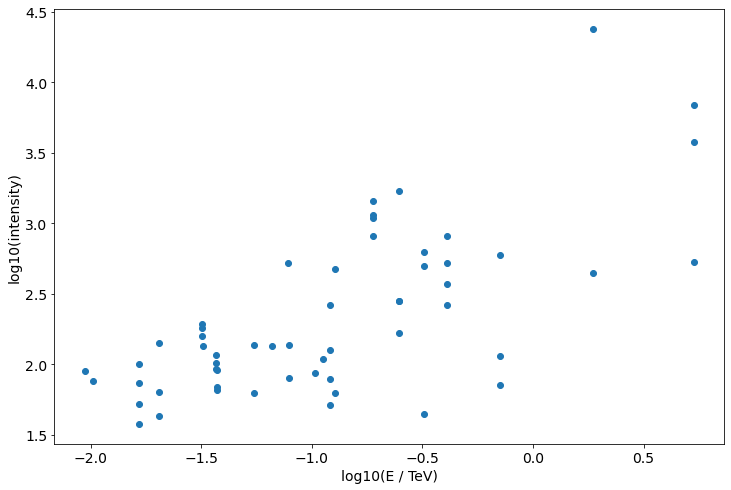

In [33]:
plt.scatter(
    np.log10(dl1_table["true_energy"].quantity / u.TeV),
    np.log10(dl1_table["hillas_intensity"]),
)
plt.xlabel('log10(E / TeV)')
plt.ylabel('log10(intensity)')
None

## Isn't python slow?

* Many of you might have heard: "Python is slow".
* That's trueish.
* All python objects are classes living on the heap, even integers.
* Looping over lots of "primitives" is quite slow compared to other languages.

⇒ Vectorize as much as possible using numpy  
⇒ Use existing interfaces to fast C / C++ / Fortran code  
⇒ Optimize using numba  

**But: "Premature Optimization is the root of all evil" — Donald Knuth**

So profile to find exactly what is slow.

### Why use python then?

* Python works very well as *glue* for libraries of all kinds of languages
* Python has a rich ecosystem for data science, physics, algorithms, astronomy

### Example: Number of Islands

Find all groups of pixels, that survived the cleaning

In [34]:
from ctapipe.image import toymodel
from ctapipe.instrument import CameraGeometry


geometry = CameraGeometry.from_name('LSTCam')

Let's create a toy images with several islands;

In [35]:
np.random.seed(42)

image = np.zeros(geometry.n_pixels)


for i in range(9):
    
    model = toymodel.Gaussian(
        x=np.random.uniform(-0.8, 0.8) * u.m,
        y=np.random.uniform(-0.8, 0.8) * u.m,
        width=np.random.uniform(0.05, 0.075) * u.m,
        length=np.random.uniform(0.1, 0.15) * u.m,
        psi=np.random.uniform(0, 2 * np.pi) * u.rad,
    )

    new_image, sig, bg = model.generate_image(
        geometry, 
        intensity=np.random.uniform(1000, 3000),
        nsb_level_pe=5
    )
    image += new_image

In [36]:
clean = tailcuts_clean(geometry, image, picture_thresh=10, boundary_thresh=5, min_number_picture_neighbors=2)

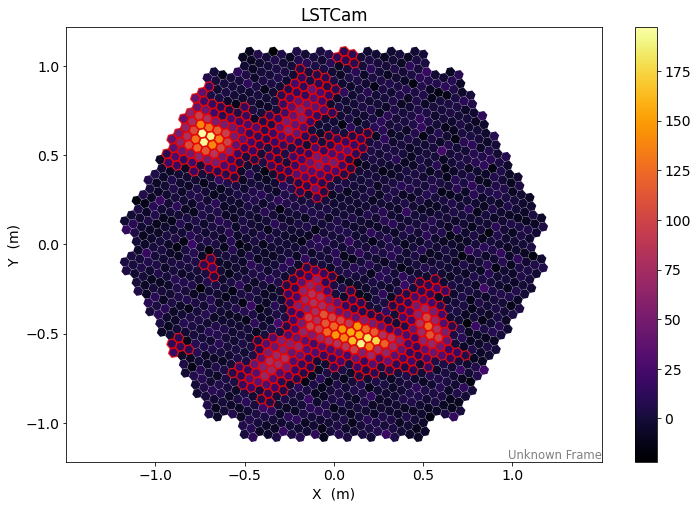

In [37]:
disp = CameraDisplay(geometry)
disp.image = image
disp.highlight_pixels(clean, color='xkcd:red', linewidth=1.5)
disp.add_colorbar()

In [38]:
def num_islands_python(camera, clean):
    ''' A breadth first search to find connected islands of neighboring pixels in the cleaning set'''
    
    # the camera geometry has a [n_pixel, n_pixel] boolean array
    # that is True where two pixels are neighbors
    neighbors = camera.neighbor_matrix
    
    island_ids = np.zeros(camera.n_pixels)
    current_island = 0
    
    # a set to remember which pixels we already visited
    visited = set()

    # go only through the pixels, that survived cleaning
    for pix_id in np.where(clean)[0]:
        if pix_id not in visited:
            # remember that we already checked this pixel
            visited.add(pix_id)
            
            # if we land in the outer loop again, we found a new island
            current_island += 1
            island_ids[pix_id] = current_island
            
            # now check all neighbors of the current pixel recursively
            to_check = set(np.where(neighbors[pix_id] & clean)[0])
            while to_check:
                pix_id = to_check.pop()
                
                if pix_id not in visited:    
                    visited.add(pix_id)
                    island_ids[pix_id] = current_island
                    
                    to_check.update(np.where(neighbors[pix_id] & clean)[0])
    
    n_islands = current_island
    return n_islands, island_ids

In [39]:
n_islands, island_ids = num_islands_python(geometry, clean)

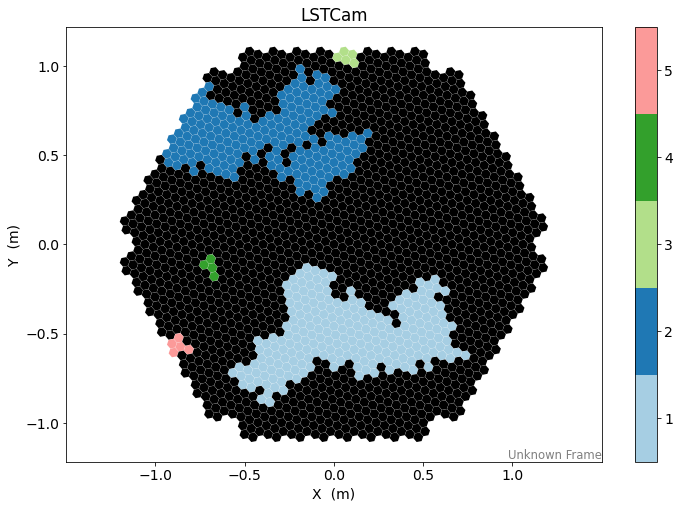

In [40]:
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('Paired')
cmap = ListedColormap(cmap.colors[:n_islands])
cmap.set_under('k')

disp = CameraDisplay(geometry)
disp.image = island_ids
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands + 0.5)
disp.add_colorbar()

In [41]:
%timeit num_islands_python(geometry, clean)

2.9 ms ± 50 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
from scipy.sparse.csgraph import connected_components

def num_islands_scipy(geometry, clean):
    neighbors = geometry.neighbor_matrix_sparse
    
    clean_neighbors = neighbors[clean][:, clean]
    num_islands, labels = connected_components(clean_neighbors, directed=False)
    
    island_ids = np.zeros(geometry.n_pixels)
    island_ids[clean] = labels + 1
    
    return num_islands, island_ids

In [43]:
n_islands_s, island_ids_s = num_islands_scipy(geometry, clean)

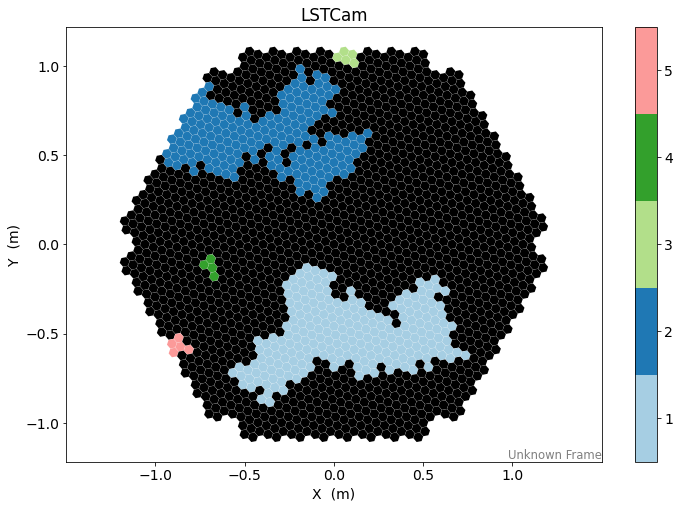

In [44]:
disp = CameraDisplay(geometry)
disp.image = island_ids_s
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands_s + 0.5)
disp.add_colorbar()

In [45]:
%timeit num_islands_scipy(geometry, clean)

705 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**A lot less code, and a factor 3 speed improvement**

Finally, current ctapipe implementation is using numba:

In [46]:
%timeit number_of_islands(geometry, clean)

40.2 µs ± 742 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
